In [1]:
GPU = 0
num_workers = 4
seed = 42
target_name = 'p'
exclude_pairs = [["DMN","DMN"]]
patch_size_ratio = 1
repeat_num = 1

model_path = "/users/hjd/HJW_take_over/SNUH_hjd/best_models_for_manuscript/pretrain_model/Hsp:[0.95,0.3,0.3]_Maxb:[0.01, 0.05, 0.05]_Betalr:[0.0001, 0.001, 0.001]_LR:[5e-05]_Act:[elu]_Opt:[nag]_DO:[0.9,0.9,0.0]_lambda:[0.01]"

In [2]:
location = 'BSPL'
data_path_dict={
    'BSPL':{
        "Parcel":"/data2/alumni/hjw/data/ABCD/Parcels/Parcels.xlsx",
        "Gordon":"/data2/alumni/hjw/data/ABCD/npz_files/Gordon_network_labels.npz",
        "ABCD_rsfc":"/data2/alumni/hjw/data/ABCD/npz_files/rsfc_p_site_scanner_si_ge.npz",
        "ABCD_CFA":"/data4/SNU/data/ABCD_CFA_5factor.npz",
#         "SNUH_rsfc":f"/data4/SNU/data/snuh_fc_temp_hjd/RSFC_Smoothing[{smoothing}]_GSR[{gsr}]_Censor[{censor}].npz",
        "SNUH_demo":"/users/hjd/Revision/demo_for_rsfc_df.csv",
        "SNUH_CFA":"",
    },
}

In [3]:
import sklearn, torch
sklearn.__version__, torch.__version__

('0.24.1', '1.8.1+cu102')

In [4]:
temp_sel_idx = 0
n_cv = 5

import numpy as np
sel_cv_idx = 0
jump_val = n_cv
outer_cv_part = np.arange(sel_cv_idx * jump_val, sel_cv_idx * jump_val + jump_val)
print("Total Fold: {}".format(outer_cv_part))

select_fold = outer_cv_part
print("Selected Fold: {}".format(select_fold))

Total Fold: [0 1 2 3 4]
Selected Fold: [0 1 2 3 4]


In [5]:
from sklearn.model_selection import ParameterGrid

act_func_name = "elu"
optimizer_name = "nag"

h1_cand = [1024]
h2_cand = [1024]

dropout_h1_cand = [0.3]
dropout_h2_cand = [0.3]
batch_size_cand = [4]
lr_cand = [4e-05]
lr_patience_cand = [5]
lr_factor_cand = [0.5]
epochs_cand = [150]

hsp_h1_cand = [0.95]
hsp_h2_cand = [0.3]

l2_param_cand = [2e-01]

pretrain_cand = [True]
trainable_ext_cand = [False]
trainable_prd_cand = [True]

param_cand = {
    "h1": h1_cand, "h2": h2_cand,  
    "dropout_h1": dropout_h1_cand, "dropout_h2": dropout_h2_cand,
    "batch_size": batch_size_cand, "lr": lr_cand, "epochs": epochs_cand, 
    "lr_patience": lr_patience_cand, "lr_factor": lr_factor_cand,
    "hsp_h1": hsp_h1_cand, "hsp_h2": hsp_h2_cand, "l2_param": l2_param_cand,
    "pretrain": pretrain_cand, 
    "freeze_ext": trainable_ext_cand, "freeze_prd": trainable_prd_cand
}

In [6]:
import gc
import itertools
import math
import os
import pickle
import random
import time
from datetime import datetime as dt
from decimal import Decimal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pytz import timezone
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

from PIL import Image
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Function, Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingWarmRestarts
from torch.optim.swa_utils import SWALR, AveragedModel
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [7]:
def seed_everything(seed=seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(seed)

nowtime = dt.now(timezone("Asia/Seoul")); year = str(nowtime.year)[2:]
month = '0{}'.format(nowtime.month) if nowtime.month < 10 else str(nowtime.month)
day = '0{}'.format(nowtime.day) if nowtime.day < 10 else str(nowtime.day)
hour = '0{}'.format(nowtime.hour) if nowtime.hour < 10 else str(nowtime.hour)
minute = '0{}'.format(nowtime.minute) if nowtime.minute < 10 else str(nowtime.minute)
sec = '0{}'.format(nowtime.second) if nowtime.second < 10 else str(nowtime.second)
msec = str(nowtime.microsecond)[:2]

In [8]:
def exclude_fn_pairs(input_rsfc,exclude_pairs,patch_ratio):
    
    tot_rois = 352

    parcels = pd.read_excel("/data2/alumni/hjw/data/ABCD/Parcels/Parcels.xlsx", engine="openpyxl")
    networks = list(parcels["Community"]) + 19 * ["Subcortex"]
    networks_df = pd.DataFrame(networks, columns=["network"])
    networks_df[networks_df["network"] == "Auditory"] = "AUD"
    networks_df[networks_df["network"] == "Visual"] = "VIS"
    networks_df[networks_df["network"] == "VentralAttn"] = "VAN"
    networks_df[networks_df["network"] == "Subcortex"] = "SCN"
    networks_df[networks_df["network"] == "Salience"] = "SAL"
    networks_df[networks_df["network"] == "SMmouth"] = "SMM"
    networks_df[networks_df["network"] == "SMhand"] = "SMH"
    networks_df[networks_df["network"] == "RetrosplenialTemporal"] = "RSP"
    networks_df[networks_df["network"] == "None"] = "NONE"
    networks_df[networks_df["network"] == "FrontoParietal"] = "FPN"
    networks_df[networks_df["network"] == "DorsalAttn"] = "DAN"
    networks_df[networks_df["network"] == "Default"] = "DMN"
    networks_df[networks_df["network"] == "CinguloParietal"] = "CPAR"
    networks_df[networks_df["network"] == "CinguloOperc"] = "CON"

    orig_networks = networks_df['network'].tolist()
    networks_label = sorted(np.unique(networks_df['network'].values))
    new_networks_label = networks_label.copy()
    new_networks_label.remove("NONE")
    new_networks_label.append("NONE")

    new_orig_network_order = {
        key:value for (key, value) in 
        zip(new_networks_label, (np.arange(len(new_networks_label))))
    }


    sorted_networks = pd.DataFrame(index=orig_networks).sort_index(key=lambda x: x.map(new_orig_network_order), axis=0).index.tolist()
    sorted_networks_df = pd.DataFrame(np.unique(sorted_networks, return_index=True)).T
    sorted_networks_df.columns = ["networks", "n"]
    sorted_networks_df = sorted_networks_df.sort_values(
        by="networks", key=lambda x: x.map(new_orig_network_order)
    )

    for idx,vec in enumerate(input_rsfc):
        wfm = np.zeros((tot_rois, tot_rois))
        iu_non_di_idx = np.mask_indices(tot_rois, np.triu, 1)
        wfm[iu_non_di_idx] = vec
        il_idx = np.tril_indices(tot_rois, -1)
        wfm[il_idx] = wfm.T[il_idx]
        wfm_df = pd.DataFrame(wfm, index=orig_networks, columns=orig_networks)

        for pairs in exclude_pairs:
            flat_fn = np.array(wfm_df.loc[pairs[0],pairs[1]]).ravel()
            fn_size = len(flat_fn)
            patch_size = int(patch_ratio*fn_size)
            patch_idx = np.random.choice(np.arange(fn_size),patch_size,replace=False)
            flat_fn[patch_idx] = 0
            recon_fn = flat_fn.reshape(wfm_df.loc[pairs[0],pairs[1]].shape)
            wfm_df.loc[pairs[0],pairs[1]] = recon_fn
            wfm_df.loc[pairs[1],pairs[0]]= recon_fn.T

        wfm_df_vis = wfm_df.copy()
        wfm_df_vis = wfm_df_vis.sort_index(key=lambda x: x.map(new_orig_network_order), axis=0)
        wfm_df_vis = wfm_df_vis.sort_index(key=lambda x: x.map(new_orig_network_order), axis=1)
        
        if idx==0:
            excluded_rsfc = wfm[iu_non_di_idx]
            excluded_rsfc_vis = np.expand_dims(np.array(wfm_df_vis),axis=0)
        else:
            excluded_rsfc = np.vstack([excluded_rsfc,wfm[iu_non_di_idx]])
            excluded_rsfc_vis = np.vstack([excluded_rsfc_vis,np.expand_dims(np.array(wfm_df_vis),axis=0)])
    if len(exclude_pairs)>0:
        return excluded_rsfc, excluded_rsfc_vis, patch_idx
    else:
        return excluded_rsfc, excluded_rsfc_vis, 0
    

In [9]:
p_factor_idx = 0

data_path = data_path_dict[location]['ABCD_rsfc']
data = np.load(data_path, allow_pickle=True)
X_original = data["X"]
if exclude_pairs ==[]:
    X = X_original, X_original
else:
    X, X_vis,_ = exclude_fn_pairs(X_original,exclude_pairs,1)

targets_all = np.load(data_path_dict[location]['ABCD_CFA'],allow_pickle=True) 
target_fs = targets_all[target_name]
target_scn = targets_all['scn']
y = target_fs.reshape(-1,1)
print(X.max(),X.min())
print(X.shape, y.shape)

7.254328727722168 -7.254328727722168
(6905, 61776) (6905, 1)


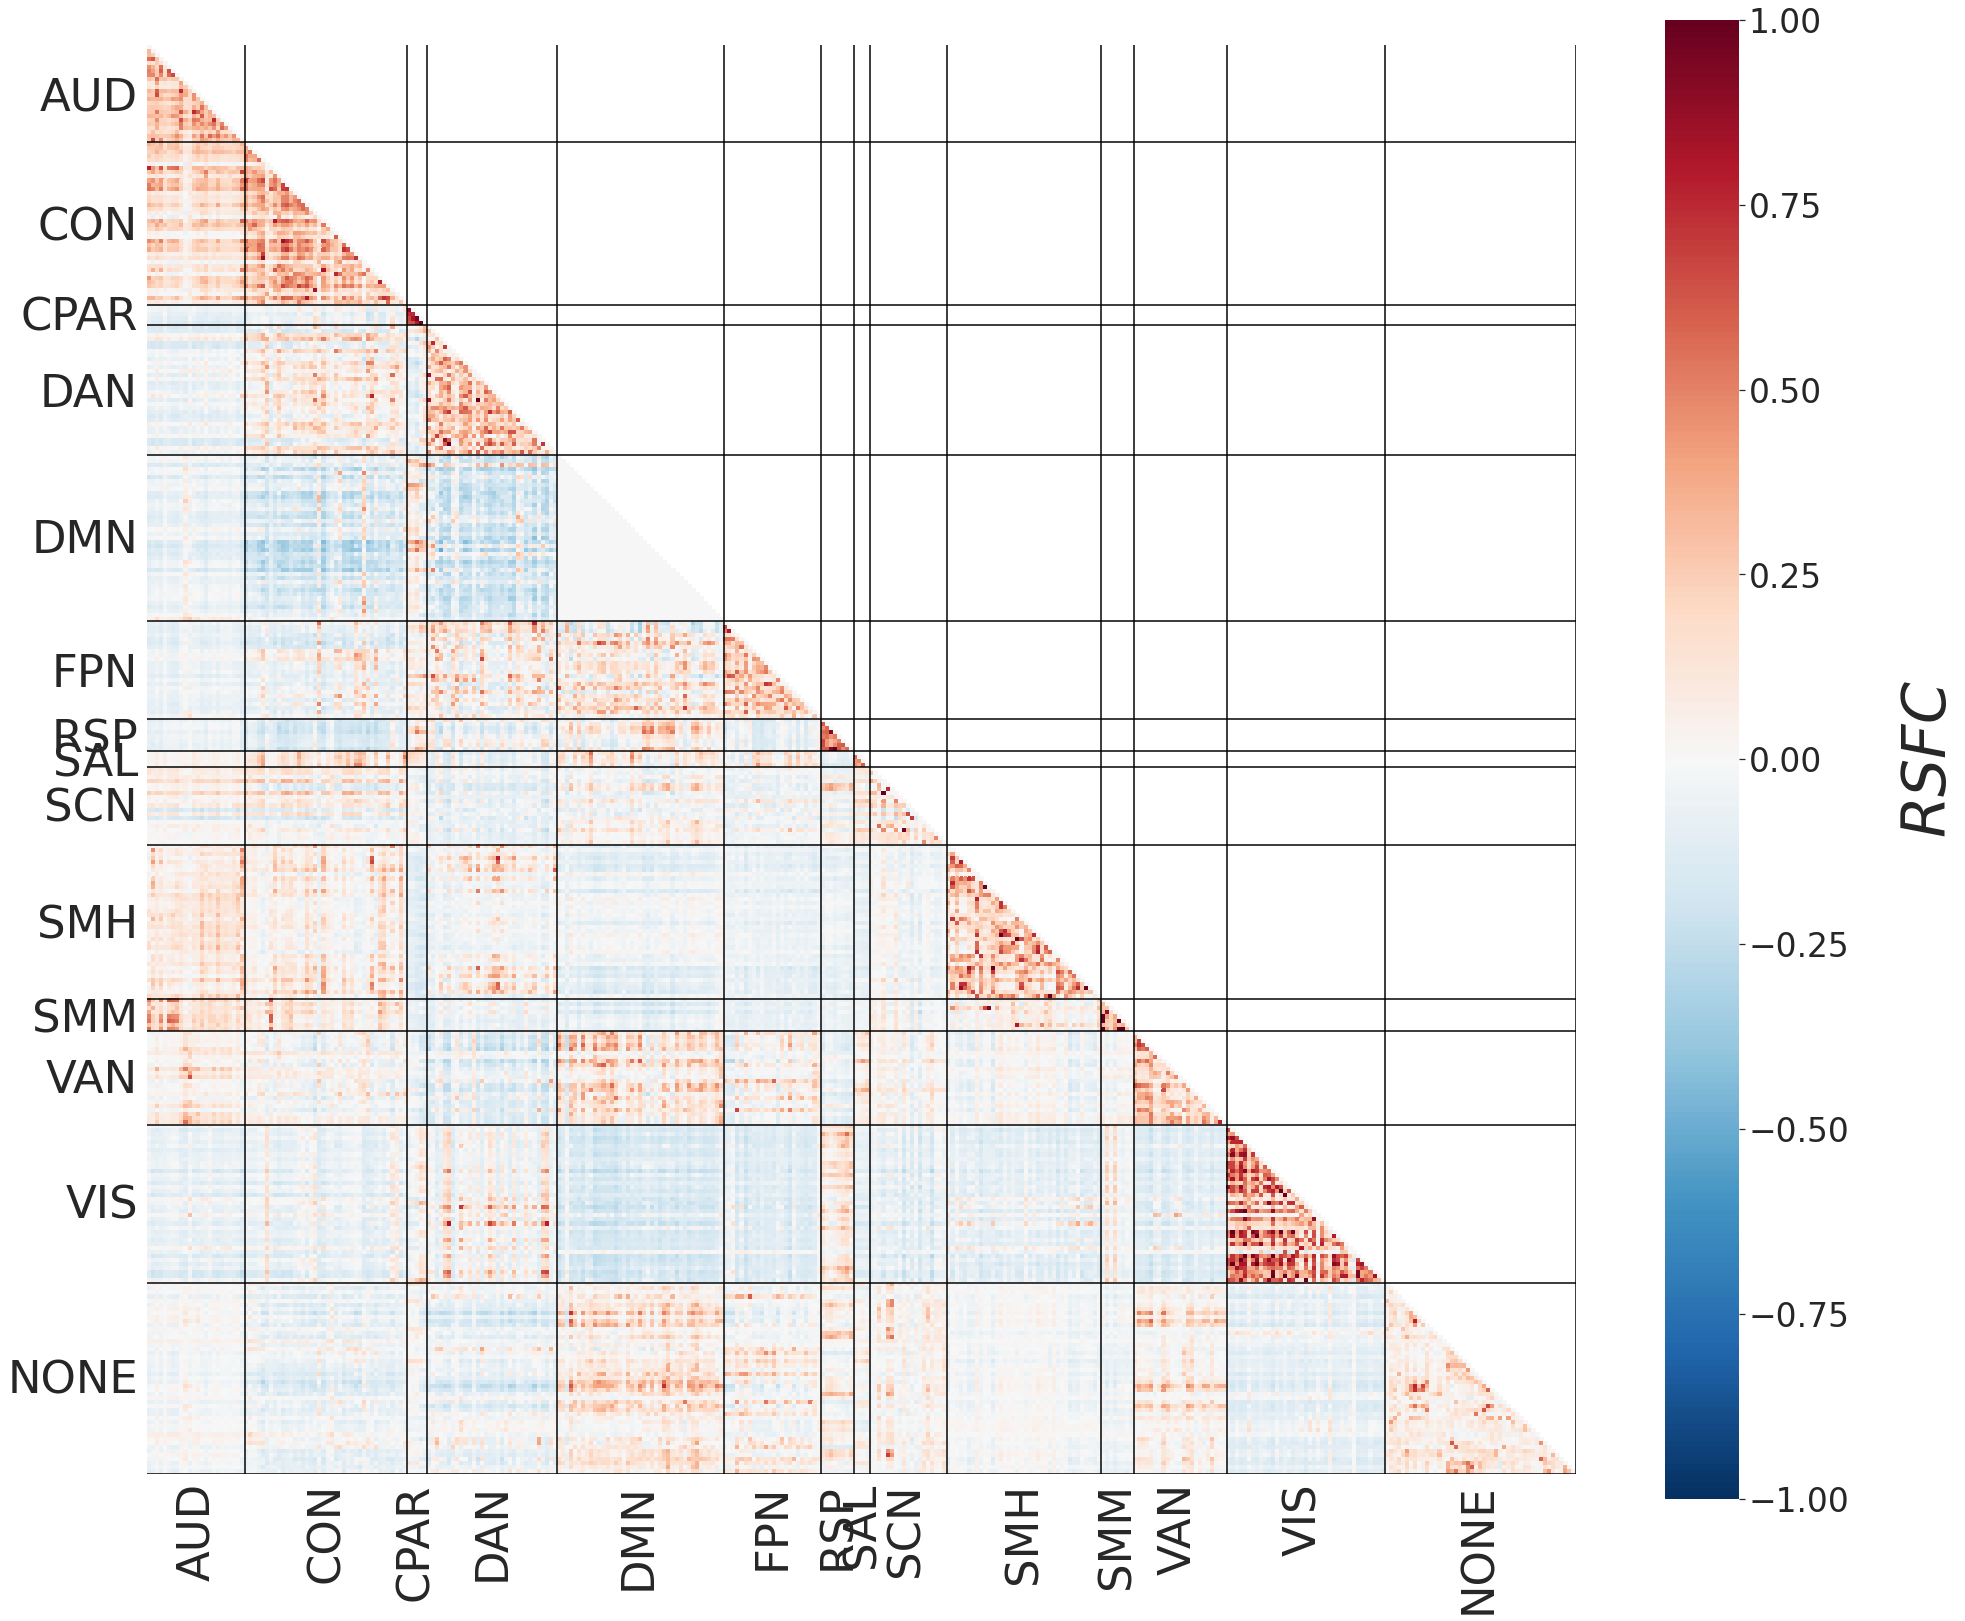

In [10]:
if exclude_pairs !=[]:
    wfm_df_vis = np.mean(X_vis,axis=0)

    tot_rois = 352

    parcels = pd.read_excel("/data2/alumni/hjw/data/ABCD/Parcels/Parcels.xlsx", engine="openpyxl")
    networks = list(parcels["Community"]) + 19 * ["Subcortex"]
    networks_df = pd.DataFrame(networks, columns=["network"])
    networks_df[networks_df["network"] == "Auditory"] = "AUD"
    networks_df[networks_df["network"] == "Visual"] = "VIS"
    networks_df[networks_df["network"] == "VentralAttn"] = "VAN"
    networks_df[networks_df["network"] == "Subcortex"] = "SCN"
    networks_df[networks_df["network"] == "Salience"] = "SAL"
    networks_df[networks_df["network"] == "SMmouth"] = "SMM"
    networks_df[networks_df["network"] == "SMhand"] = "SMH"
    networks_df[networks_df["network"] == "RetrosplenialTemporal"] = "RSP"
    networks_df[networks_df["network"] == "None"] = "NONE"
    networks_df[networks_df["network"] == "FrontoParietal"] = "FPN"
    networks_df[networks_df["network"] == "DorsalAttn"] = "DAN"
    networks_df[networks_df["network"] == "Default"] = "DMN"
    networks_df[networks_df["network"] == "CinguloParietal"] = "CPAR"
    networks_df[networks_df["network"] == "CinguloOperc"] = "CON"

    orig_networks = networks_df['network'].tolist()
    networks_label = sorted(np.unique(networks_df['network'].values))
    new_networks_label = networks_label.copy()
    new_networks_label.remove("NONE")
    new_networks_label.append("NONE")


    new_orig_network_order = {
        key:value for (key, value) in 
        zip(new_networks_label, (np.arange(len(new_networks_label))))
    }


    sorted_networks = pd.DataFrame(index=orig_networks).sort_index(key=lambda x: x.map(new_orig_network_order), axis=0).index.tolist()
    sorted_networks_df = pd.DataFrame(np.unique(sorted_networks, return_index=True)).T
    sorted_networks_df.columns = ["networks", "n"]
    sorted_networks_df = sorted_networks_df.sort_values(
        by="networks", key=lambda x: x.map(new_orig_network_order)
    )


    start_network_idx = np.array(sorted_networks_df.n)
    next_network_idx = np.hstack((start_network_idx[1:], 352))

    network_mid_idx = np.array((start_network_idx + next_network_idx) / 2, dtype=int)

    sns.set(style="white", font_scale=3)
    fig, ax = plt.subplots(figsize=(32, 32))
    cbar_kws = dict(use_gridspec=False, shrink=0.85, location="right")
    threshold = 1
    sns.heatmap(
        wfm_df_vis, square=True, cmap="RdBu_r", center=0, 
        vmax=threshold, vmin=-threshold , 
        mask=np.triu(np.ones(wfm_df_vis.shape), 1).astype(bool),
        ax=ax, cbar_kws=cbar_kws
    )

    ax.set_xticks(network_mid_idx)
    ax.set_yticks(network_mid_idx)

    ax.set_xticklabels(new_networks_label, rotation=90, fontsize=45, ha="center")
    ax.set_yticklabels(new_networks_label, rotation='horizontal', fontsize=45)

    for network_pos in next_network_idx:
        plt.axvline(network_pos, linewidth=1.5, color="black", ymin=0, ymax=network_pos)
        plt.axhline(network_pos, linewidth=1.5, color="black", xmin=0, xmax=network_pos)

    cbar = ax.collections[0].colorbar
    cbar.set_label("$RSFC$", fontsize=60, labelpad=50)


In [11]:
seed_everything(seed)

from sklearn.model_selection import KFold, ShuffleSplit

outer_n_splits = n_cv

outer_train_folds_idx = []
outer_test_folds_idx = []

outer_skf = ShuffleSplit(
    n_splits=outer_n_splits, test_size=0.20, random_state=seed)

for n_outer, (outer_train_idx, outer_test_idx) in enumerate(outer_skf.split(X, y)):
    outer_train_folds_idx.append(outer_train_idx)
    outer_test_folds_idx.append(outer_test_idx)

len(outer_train_folds_idx),len(outer_train_folds_idx[0]), len(outer_test_folds_idx[0])

(5, 5524, 1381)

In [12]:
# # Set order of network label 
new_orig_network_idx_order = [
    'AUD', 'DAN', 'CPAR', 'NONE', 
    'SAL', 'VIS', 'RSP', 'DMN',
    'SMM', 'CON', 'SCN', 
    'SMH', 'VAN', 'FPN'
]

sorted_order = sorted(new_orig_network_idx_order)
sorted_order.remove("NONE")
sorted_order.append("NONE")
new_orig_network_idx_order = sorted_order
print(new_orig_network_idx_order)

new_orig_network_order = {
    key:value for (key, value) in 
    zip(new_orig_network_idx_order, (np.arange(len(new_orig_network_idx_order))))
}

def make_wfm(vec):
    wfm = np.zeros((tot_rois, tot_rois))
    iu_non_di_idx = np.mask_indices(tot_rois, np.triu, 1)
    wfm[iu_non_di_idx] = vec
    il_idx = np.tril_indices(tot_rois, -1)
    wfm[il_idx] = wfm.T[il_idx]
    wfm_df = pd.DataFrame(wfm, index=orig_networks, columns=orig_networks)
    wfm_df = wfm_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=0)
    wfm_df = wfm_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=1)
    
    return wfm_df


#input으로 model, epoch받아서 wfm 저장시키기

def visualize_wfm(trained_model,epoch,epoch_gap = 10,threshold=False,mode = 'sum'):
    
    if epoch%epoch_gap !=0:
        return
    
    wfm_save_dir = outer_save_dir+'/WFM/'
    if not os.path.isdir(wfm_save_dir):
        os.mkdir(wfm_save_dir)
    
    w_ext = []
    w_reg = []
    w_dsc = []

    ext_hidden = trained_model.ext_1.weight.shape[0]
    prd_hidden = trained_model.prd_1.weight.shape[0]

    w = []

    for name,params in trained_model.named_parameters():
        if "weight" in name and "bn" not in name:
            if "ext" in name or "prd" in name:
                w.append(params)

    w_ext_1 = w[0].detach().cpu().numpy().T
    w_reg_1 = w[1].detach().cpu().numpy().T
    w_reg_2 = w[2].detach().cpu().numpy().T

    temp_w_ext = w_ext_1
    temp_w_reg = np.matmul(np.matmul(temp_w_ext, w_reg_1), w_reg_2)

    w_ext.append(temp_w_ext) #ext x pred1 (352x1024)
    w_reg.append(temp_w_reg) #ext x pred1 x pred2 (352x1)

#     np.savez(wfm_save_dir+"/wfm_reg_epoch{}".format(epoch), X=w_reg)

    wfm_df = make_wfm(stats.zscore(w_reg[0].reshape(-1,)))

    cols = rows = wfm_df.columns.values
#     new_orig_network_idx_order = np.unique(cols)
    avg_df_1 = pd.DataFrame(columns=cols, index=rows)
    avg_df_2 = pd.DataFrame(columns=new_orig_network_idx_order, index=new_orig_network_idx_order)
    avg_df_3 = pd.DataFrame(columns=new_orig_network_idx_order, index=new_orig_network_idx_order)

    for i, temp_row in enumerate(new_orig_network_idx_order):
        for j, temp_col in enumerate(new_orig_network_idx_order):
            temp_row_ids = np.where(rows == temp_row)[0]
            temp_col_ids = np.where(cols == temp_col)[0]
            temp_mat = wfm_df.iloc[temp_row_ids, temp_col_ids]
            temp_vec = temp_mat.values.ravel()
            n_temp_vec = np.sum(np.absolute(temp_mat.values) > 1.96)
            if mode == 'sum':
                sum_val = temp_vec.sum()
                n_val = n_temp_vec
            elif mode == 'avg':
                if temp_row == temp_col:
                    sum_val = temp_vec.sum() / (len(temp_row_ids) * (len(temp_row_ids) - 1))
                    n_val = n_temp_vec / (len(temp_row_ids) * (len(temp_row_ids) - 1))
                else:
                    sum_val = temp_vec.sum() / (len(temp_row_ids) * (len(temp_col_ids)))
                    n_val = n_temp_vec / (len(temp_row_ids) * (len(temp_col_ids)))
            avg_df_1.iloc[temp_row_ids, temp_col_ids] = sum_val
            avg_df_2.loc[temp_row, temp_col] = sum_val
            avg_df_3.loc[temp_row, temp_col] = n_val

    if threshold==False:
        avg_mat = np.array(avg_df_2.values, dtype=float)
        avg_mat = (avg_mat - avg_mat.mean()) / avg_mat.std()
        avg_mat_df = pd.DataFrame(avg_mat, columns=new_orig_network_idx_order, index=new_orig_network_idx_order)
        avg_mat_df = avg_mat_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=0)
        avg_mat_df = avg_mat_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=1)
        thr_zero = 0
        avg_mat_df[(avg_mat_df < thr_zero) & (avg_mat_df > -thr_zero)] = 0

        sns.set(style="white", font_scale=4.5)
        fig, ax = plt.subplots(figsize=(32, 32))
        threshold = np.abs(avg_mat_df.values).max()
        threshold = 5.5
        cbar_kws = dict(
            use_gridspec=False, shrink=0.85, location="right", label="Correlation ($r$)")
        sns.heatmap(
            avg_mat_df, square=True, cmap="vlag", ax=ax, 
            mask=np.triu(np.ones(avg_mat_df.shape), 1).astype(bool),
            vmax=threshold, vmin=-threshold, 
            linewidths=5, 
            cbar=True, cbar_kws=cbar_kws,
            fmt=".2f", annot=True, annot_kws={"fontsize": 32}
        )
        cbar = ax.collections[0].colorbar
        cbar.set_label("$WF$", fontsize=60, labelpad=50)
        ax.set_xticklabels(new_orig_network_order, rotation=90, fontsize=60)
        ax.set_yticklabels(new_orig_network_order, rotation=0, fontsize=60)
        plt.title(f"Epoch {epoch}/{epochs}")
        plt.savefig(wfm_save_dir+f"/{mode}_WFM_epoch{epoch}.jpg")
        plt.close(fig)
    #     plt.show()

    if threshold==True:
        avg_mat = np.array(avg_df_2.values, dtype=float)
        avg_mat = (avg_mat - avg_mat.mean()) / avg_mat.std()
        avg_mat_df = pd.DataFrame(avg_mat, columns=new_orig_network_idx_order, index=new_orig_network_idx_order)
        avg_mat_df = avg_mat_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=0)
        avg_mat_df = avg_mat_df.sort_index(key=lambda x: x.map(new_orig_network_order), axis=1)

        annot = np.vectorize(lambda x: '' if np.absolute(x) < 3.091 else str(round(x, 2)))(avg_mat_df.to_numpy())
        # annot = np.vectorize(lambda x: '' if np.absolute(x) < 2.58 else str(round(x, 2)))(avg_mat_df.to_numpy())
        # annot = np.vectorize(lambda x: '' if np.absolute(x) < 1.96 else str(round(x, 2)))(avg_mat_df.to_numpy())

        thr_zero = 0
        avg_mat_df[(avg_mat_df < thr_zero) & (avg_mat_df > -thr_zero)] = 0

        sns.set(style="white", font_scale=5)
        plt.rcParams['mathtext.fontset'] = 'custom'
        plt.rcParams['mathtext.it'] = 'Arial:italic'
        plt.rcParams['mathtext.rm'] = 'Arial'

        fig, ax = plt.subplots(figsize=(32, 32))
        threshold = np.abs(avg_mat_df.values).max()
        threshold = 7
        cbar_kws = dict(
            use_gridspec=False, shrink=0.85, location="right", label="Correlation ($r$)")
        sns.heatmap(
            avg_mat_df, square=True, cmap="vlag",
            ax=ax,
            mask=np.triu(np.ones(avg_mat_df.shape), 1).astype(bool),
            vmax=threshold, vmin=-threshold, 
            linewidths=5, 
            cbar=True, cbar_kws=cbar_kws,
            fmt="", annot=annot, annot_kws={"fontsize": 36}
        )
        cbar = ax.collections[0].colorbar
        cbar.set_label("$WF$", fontsize=60, labelpad=50)
        ax.set_xticklabels(new_orig_network_order, rotation=90, fontsize=60)
        ax.set_yticklabels(new_orig_network_order, rotation=0, fontsize=60)
        plt.title(f"Epoch {epoch}/{epochs}")
        plt.savefig(wfm_save_dir+f"/{mode}_WFM_epoch{epoch}.jpg")
        plt.close(fig)
    #     plt.show()
    
    return

def plot_prediction_result(epoch,pearsonr,valid_prediction,valid_true):
    
    pred_save_dir = outer_save_dir+'/Prediction/'
    if not os.path.isdir(pred_save_dir):
        os.mkdir(pred_save_dir)
    
    sns.set(style="darkgrid", font_scale=2)
    plt.figure(figsize=(10,7))
    fig = sns.scatterplot(valid_true, valid_prediction,s=100)
    plt.title(f"Epoch {epoch}/{epochs}, Pearson's r : %.3f" % pearsonr)
    plt.xlabel("True $p$-factor")
    plt.ylabel("Predicted $p$-factor")
    plt.tight_layout()
    plt.ylim(np.min(valid_prediction)-0.0002,np.max(valid_prediction)+0.0002)
    plt.savefig(pred_save_dir+f"/Prediction_epoch{epoch}.png")
    plt.close()
    return 

['AUD', 'CON', 'CPAR', 'DAN', 'DMN', 'FPN', 'RSP', 'SAL', 'SCN', 'SMH', 'SMM', 'VAN', 'VIS', 'NONE']


In [13]:
mode = "max"
min_lr = 1e-08
lr_alpha = -1.5
lr_beta = 1.7

momentum = 0.90
l1_param = 0
early_stopping_patience = 150

input_dim = X.shape[1]
n_classes = 1
output_dim = n_classes

wsc_flag = [0, 0]
beta_lr = [5e-03, 1e-02]
max_beta = [5e-02, 1e-01]
n_wsc = wsc_flag.count(1)

In [14]:
# Training dataset
class TrainDataset(Dataset): 
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, idx): 
        X_train = torch.from_numpy(self.X_train[idx]).type(torch.FloatTensor)
        y_train = torch.from_numpy(self.y_train[idx]).type(torch.FloatTensor)

        return X_train, y_train
    
# Test dataset
class TestDataset(Dataset): 
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        
    def __len__(self):
        return len(self.X_test)
    
    def __getitem__(self, idx): 
        X_test = torch.from_numpy(self.X_test[idx]).type(torch.FloatTensor)
        y_test = torch.from_numpy(self.y_test[idx]).type(torch.FloatTensor)
        
        return X_test, y_test
    
    
class DNN(nn.Module):
    def __init__(self, h1, h2, dropout_h1, dropout_h2, act_func_name):
        super(DNN, self).__init__()
        self.ext_1 = nn.Linear(input_dim, h1)
        self.ext_bn_1 = nn.BatchNorm1d(h1)
        
        self.prd_1 = nn.Linear(h1, h2)
        self.prd_bn_1 = nn.BatchNorm1d(h2)
        self.prd_2 = nn.Linear(h2, output_dim)
        
        self.dropout_h1 = nn.Dropout(p=dropout_h1)
        self.dropout_h2 = nn.Dropout(p=dropout_h2)
        
        self.act_func = get_act_func(act_func_name)
        self.weights_init()
    
    def forward(self, x):
        x = self.ext_1(x)
        x = self.ext_bn_1(x)
        x = self.act_func(x)
        x = self.dropout_h1(x)
        
        x = self.prd_1(x)
        x = self.prd_bn_1(x)
        x = self.act_func(x)
        x = self.dropout_h2(x)
        out = self.prd_2(x)
        
        return out
    
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                nn.init.normal_(m.bias, std=0.01)
    
def get_optimizer(model, opt_name, learning_rate=None, l2_param=None):
    lower_opt_name = opt_name.lower()
    if lower_opt_name == 'momentum':
        return optim.SGD(model.parameters(), lr=learning_rate, 
                         momentum=momentum, weight_decay=l2_param)
    elif lower_opt_name == 'nag':
        return optim.SGD(model.parameters(), lr=learning_rate, 
                         momentum=momentum, weight_decay=l2_param, nesterov=True)
    elif lower_opt_name == 'adam':
        return optim.Adam(model.parameters(), lr=learning_rate, 
                          weight_decay=l2_param)
    elif lower_opt_name == 'sparseadam':
        return optim.SparseAdam(model.parameters(), lr=learning_rate,
                       betas=(0.9, 0.999), eps=1e-08, maximize=False)
    elif lower_opt_name == 'radam':
        return optim.RAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999),
                           eps=1e-08, weight_decay=l2_param)
    elif lower_opt_name == 'nadam':
        return optim.NAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
                  weight_decay=l2_param, momentum_decay=0.004)
    elif lower_opt_name == 'adamax':
        return optim.Adamax(model.parameters(), lr=learning_rate, betas=(0.9, 0.999),
                            eps=1e-08, weight_decay=l2_param)
    else:
        sys.exit("Illegal arguement for optimizer type")
        
def get_act_func(act_func_name):
    act_func_name = act_func_name.lower()
    if act_func_name == 'relu':
        return nn.ReLU()
    elif act_func_name == 'prelu':
        return nn.PReLU()
    elif act_func_name == 'elu':
        return nn.ELU()
    elif act_func_name == 'silu':
        return nn.SiLU()
    elif act_func_name == 'leakyrelu':
        return nn.LeakyReLU()
    elif act_func_name == 'tanh':
        return nn.Tanh()
    elif act_func_name == 'selu':
        return nn.SELU()
    elif act_func_name == 'gelu':
        return nn.GELU()
    else:
        sys.exit("Illegal arguement for activation function type")
        
def init_hsp(n_wsc, epochs):
    hsp_val = torch.zeros(n_wsc)
    beta_val = torch.clone(hsp_val)
    hsp_list = torch.zeros((n_wsc, epochs))
    beta_list = torch.zeros((n_wsc, epochs))
    
    return hsp_val, beta_val, hsp_list, beta_list

# Weight sparsity control with Hoyer's sparsness (Layer wise)
def calc_hsp(w, beta, max_beta, beta_lr, tg_hsp):
    
    # Get value of weight
    [dim, n_nodes] = w.shape
    num_elements = dim * n_nodes
    norm_ratio = torch.norm(w.detach(), 1) / torch.norm(w.detach(), 2)

    # Calculate hoyer's sparsity level
    num = math.sqrt(num_elements) - norm_ratio
    den = math.sqrt(num_elements) - 1
    hsp = torch.tensor(num / den).to(device)

    # Update beta
    beta = beta.clone() + beta_lr * torch.sign(torch.tensor(tg_hsp).to(device) - hsp)
    
    # Trim value
    beta = 0 if beta < 0 else beta
    beta = max_beta if beta > max_beta else beta

    return [hsp, beta]

def calc_l1(model, epoch, hsp_val, beta_val, hsp_list, beta_list, tg_hsp):
    l1_reg = None
    layer_idx = 0
    wsc_idx = 0

    for name, param in model.named_parameters():
        if "weight" in name and "bn" not in name:
            if "ext" in name or "prd_1" in name:
                temp_w = param
                
                if wsc_flag[layer_idx] != 0:
                    hsp_val[wsc_idx], beta_val[wsc_idx] = calc_hsp(
                        temp_w, beta_val[wsc_idx], max_beta[wsc_idx], 
                        beta_lr[wsc_idx], tg_hsp[wsc_idx]
                    )
                    hsp_list[wsc_idx, epoch - 1] = hsp_val[wsc_idx]
                    beta_list[wsc_idx, epoch - 1] = beta_val[wsc_idx]
                    layer_reg = torch.norm(temp_w, 1) * beta_val[wsc_idx].clone()
                    wsc_idx += 1
                else:
                    layer_reg = torch.norm(temp_w, 1) * l1_param

                if l1_reg is None:
                    l1_reg = layer_reg
                else:
                    l1_reg = l1_reg + layer_reg
                layer_idx += 1
        
    return l1_reg

In [15]:
def test(model, epoch, test_loader, criterion):
    model.eval()
    test_loss = 0
    test_acc = 0
    total = 0
    y_test_true = []
    y_test_pred = []
    
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(test_loader):
            input, target = input.to(device), target.to(device)
            pred, target = model(input), target.view(-1, 1)
            running_loss = criterion(pred, target)
            test_loss += running_loss.item()
            total += pred.size(0)

            true_batch = torch.flatten(target).detach().cpu().numpy()
            pred_batch = torch.flatten(pred).detach().cpu().numpy()
            y_test_true.extend(true_batch)
            y_test_pred.extend(pred_batch)

        test_acc,test_p = stats.pearsonr(y_test_true, y_test_pred)
        test_loss = test_loss / (batch_idx+1)
        test_mae = mean_absolute_error(y_test_pred,y_test_true)
        test_error = np.array(y_test_true)-np.array(y_test_pred)
        test_result_dict['True'].extend(np.array(y_test_true))
        test_result_dict['Prediction'].extend(np.array(y_test_pred))

    return test_mae, test_acc, test_p,test_error

In [16]:
param_grid = list(ParameterGrid(param_cand))

temp_param = param_grid[temp_sel_idx]

h1 = temp_param["h1"]
h2 = temp_param["h2"]

dropout_h1 = temp_param["dropout_h1"]
dropout_h2 = temp_param["dropout_h2"]

pretrain = temp_param["pretrain"]
freeze_ext = temp_param["freeze_ext"]
freeze_prd = temp_param["freeze_prd"]

batch_size = temp_param["batch_size"]
learning_rate = temp_param["lr"]
epochs = temp_param["epochs"]
l2_param = temp_param["l2_param"]

lr_patience = temp_param["lr_patience"]
lr_factor = temp_param["lr_factor"]

In [17]:
result_df_fin = pd.DataFrame()
idx = 0
test_error_dict = dict()
test_result_dict = {'True':[],'Prediction':[]}


result_df = pd.DataFrame()
for n_outer_cv in select_fold+1:
    print(n_outer_cv, end=' ')

    outer_test_idx = outer_test_folds_idx[n_outer_cv-1]
    X_test, y_test = X[outer_test_idx], y[outer_test_idx]
    X_test = stats.zscore(X_test, axis=1)
    outer_test_dataset = TestDataset(X_test, y_test)
    outer_test_loader = DataLoader(
        outer_test_dataset, batch_size=len(y_test), pin_memory=True,
        shuffle=True, num_workers=num_workers, drop_last=True)

    model = DNN(h1, h2, dropout_h1, dropout_h2, act_func_name).to(device)


    fold_model_path = os.path.join(model_path,f"Outer_fold_{n_outer_cv}/model_fold_{n_outer_cv}.pt")
    tmp_model = torch.load(fold_model_path)
    current_state_dict = model.state_dict()
    for key, value in tmp_model.items():
        if key in current_state_dict.keys():
            current_state_dict[key] = value
    model.load_state_dict(current_state_dict)
    model.eval()

    criterion = nn.L1Loss() 
    test_loss, test_acc, test_p,test_error = test(model, 1, outer_test_loader, criterion)
    result_df.loc[n_outer_cv,'test_loss']=test_loss
    result_df.loc[n_outer_cv,'test_acc']=test_acc
    result_df.loc[n_outer_cv,'test_p']=test_p
    test_error_dict[str(n_outer_cv)] = test_error

1 2 3 4 5 

In [18]:
loss_mean,loss_std = np.round(result_df['test_loss'].mean(),3),np.round(result_df['test_loss'].std(),3)
corr_mean, corr_std = np.round(result_df['test_acc'].mean(),3),np.round(result_df['test_acc'].std(),3)

print(f"Loss {loss_mean} +- {loss_std}")
print(f"Corr {corr_mean} +- {corr_std}")

Loss 0.447 +- 0.007
Corr 0.151 +- 0.02


In [19]:
result_df

,test_loss,test_acc,test_p
1,0.442076,0.185163,4.068039e-12
2,0.443750,0.135255,4.535855e-07
3,0.458452,0.134896,4.867427e-07
4,0.446866,0.149785,2.234020e-08
5,0.442967,0.149970,2.146081e-08


In [ ]:
# result_df.to_csv(f"/users/hjd/Revision/data/pre_training/pretraining_result_excluding_{str(exclude_pairs)}")

In [21]:
# np.save(f"/users/hjd/Revision/data/pre_training/ABCD_rsfc_excluding_{str(exclude_pairs)}",X)